# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

#### Изучаем общую информацию о полученных данных

In [3]:
pd.set_option('display.max_columns', None)
data.head(10) # Выводим на экран первые 10 строк

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [4]:
#data.info()

#### Построим  общую гистограмму для всех числовых столбцов таблицы.

In [5]:
#data.hist(figsize=(15, 20));

#### Предварительна оценка проблем с данными ####

- Названия столбцов: соответствуют нотациям, кроме одного столбца.
- Прпуски данных: в нескольких столбцах имеются пропущенные значения. Например в солбцах balcony и ceiling_height их величина превышает  30% от всех значений. 
- Дубликаты: необходимо проверить данные на явные и неявные дубликаты с целью удаления или замены. 
- Тип данных: тип данных в нескольких столбцах должен быть изменен, например:
        first_day_exposition -> date
        floors_total -> Int8 nullable-integer extension dtype
        is_apartment -> bool 
        прочее
 - Значения: Анализ гистограмм показывает наличие "длинных хвостов" у нескольких переменных, а также выбивающиеся из логики значения, например в last_price, total_area и другие. 
 
 ###### В рамках работы по предобработке данных могут быть выявлены другие проблемы, которые надо будет решить или устранить. #######

### Предобработка данных

#### Переименуем столбцы, которые имеют названия,  не соответствующие нотациям 

In [6]:
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)# 

#### Проверим массив на наличие пропусков 

In [7]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
# Делаем замены в тех столбцах, которые мы определили 
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['is_apartment'] = data['is_apartment'].fillna('False')
data['balcony'] = data['balcony'].fillna(0)
data['locality_name'].dropna(inplace=True)
data['floors_total'].dropna(inplace=True)


###### проверяем резульат замены 

In [9]:
data.info()# 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Изменение типов данных

Опрелеляем, какие столбцы будут изменены
last_price - int64

first_day_exposition - date

floors_total - Int8 nullable-integer extension dtype

is_apartment - bool

balcony - int8

days_exposition - int64

Изменение типа first_day_exposition необходимо, чтобы можно было работать в дальнейшем как с датой.
Изменение типа is_apartment необходимо, чтобы работать с булевым значением и сэкономить память.

Изменение типов во всех остальных случаях необзодимо, чтобы сэкономить память.

In [10]:
try:
    data['last_price'] = data['last_price'].astype('int64')
    print('1 done')
except:
    print('last_price int type conversion fail')
    
try:    
    data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
    print('2 done')
except:
    print('first_day_exposition to_datetime type conversion fail')
    
try:
    data['floors_total'] =  data['floors_total'].astype('Int8')
    print('3 done')
except:
    print('floors_total int8 type conversion fail')
      
try:
    data['is_apartment'] = data['is_apartment'].map({'False':False, 'True':True})
    print('4 done')
except:
    print('is_apartment bool type conversion fail')
        
try:
    data['balcony'] = data['balcony'].astype('int8')
    print('5 done')
except:
    print('balcony int8 type conversion fail')
    
try:
    data['days_exposition'] = np.floor(pd.to_numeric(data['days_exposition'], errors='coerce')).astype('Int64')
    print('6 done')
except:
    print('days_exposition int64 type conversion fail')

1 done
2 done
3 done
4 done
5 done
6 done


<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b> 
<br>Изменение типов данных проведено верно. Можно ещё заменить тип данных с float64 на float32 для экономии памяти.
</div>

Проверим данные

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  Int8          
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          20924 non-null  object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

#### Изучение уникальных значений

In [12]:
data['locality_name'].unique().shape[0]

365

#### удаление дубликатов

- Приводим всё к нижнему регистру
- Заменяем все "ё" на "е"
- Заменяем "городской поселок" на "поселок городского типа"


In [13]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')

Проверяем наличие явных дубликатов

In [14]:
print('Количетво явных дубликатов:', data.duplicated().sum())

Количетво явных дубликатов: 0


Устраняем неявные дубликаты, например:
«поселок Рябово» и «поселок городского типа Рябово»

In [15]:
locality_township = []

for i in data['locality_name'].unique():
    try:
        if 'городского типа' in i:
            locality_township.append(i)
    except:
         print('Ошибка в цикле из-за значения:', i)

unique_locality = pd.Series(data['locality_name'].unique())

print(unique_locality)

Ошибка в цикле из-за значения: nan
0                      санкт-петербург
1                       поселок шушары
2      поселок городского типа янино-1
3                    поселок парголово
4                       поселок мурино
                    ...               
319                     деревня нижняя
320          коттеджный поселок лесное
321                  деревня тихковицы
322             деревня борисова грива
323               поселок дзержинского
Length: 324, dtype: object


In [16]:
locality_df = pd.DataFrame(locality_township)
locality_df = locality_df.rename(columns={0:'name'})
locality_df['name'] = locality_df['name'].str.replace('поселок городского типа ', '')

for index, row in locality_df.iterrows():
    if unique_locality.str.contains(row['name']).sum() > 1:
        print(row['name'])
        data['locality_name'] = data['locality_name'].str.replace('поселок '+row['name'], 'поселок городского типа '+row['name'])
        
            

павлово
рахья
федоровское
приладожский
рябово


<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b> 
<br>Супер! Здесь всё верно)
</div>

#### Устранение выбросов

Рассмотрим как распределены зачения в Датафрейме

In [17]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23613.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.724358,10.673824,34.457852,5.892358,10.569807,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,0.988298,6.597173,22.030445,4.885249,5.905438,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


#### Найдем и устраним редкие и выбивающиеся из логики значения ####

Все нормально с данными в столбцах: 

total_images
floors_total
floor
balcony	airports_nearest	
city_centers_nearest	
parks_around3000	
parks_nearest
ponds_around3000	
ponds_nearest	
days_expositi

Столбец last_price - посмотрим на квартиры от 0 до 20 млн руб.,
Квартир стоимостью 0 - нет. Есть одна квартира стоимостью меньше 100 000, её мы учитывать не будем.
225 квартир стоимостью меньше 1 млн - не похоже на выброс, оставляем.
Убираем слишком дорогие квартиры стоимостью больше 100.000.000.

In [18]:
print('Квартир стоимостью 0:', data.query('last_price == 0')['last_price'].count())
print('Квартир стоимостью меньше 100.000:', data.query('last_price < 100000')['last_price'].count())
print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 100000000')['last_price'].count())
print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 100000000')['last_price'].count())
data.drop(index=data.query('last_price > 100000000').index,inplace=True)

Квартир стоимостью 0: 0
Квартир стоимостью меньше 100.000: 1
Квартир стоимостью больше 100.000.000: 37
Квартир стоимостью больше 100.000.000: 37


total_area - нет квартир площадью меньше 10 кв.м., но есть меньше 20 , что похоже не является ошибкой.
На других сайтах по недвижимости (например cian), такие квартиры тоже есть.
Квартиры со слишком большой площадью более 500 кв.м. лучше удалить.

Квартир площадью менее 10 кв.м.: 0
Квартир площадью более 500 кв.м.: 3


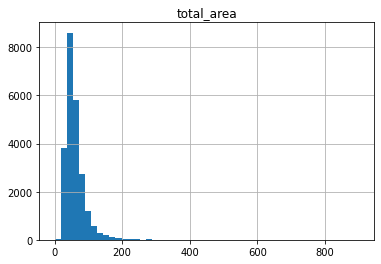

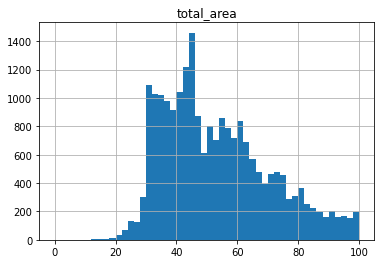

In [19]:
print('Квартир площадью менее 10 кв.м.:',data.query('total_area < 10')['total_area'].count()) 
print('Квартир площадью более 500 кв.м.:',data.query('total_area > 500')['total_area'].count())

data.drop(index=data.query('total_area > 500').index,inplace=True)

data.hist('total_area', bins=50, range=(0,900));
data.hist('total_area', bins=50, range=(0,100));

rooms - есть нулевые значения, 195.
Проверим, может это студии, апартаменты или свободная планировка?
Похоже так и есть.
Квартиры без комнат не апартаменты и не свободная планировка - 0.
Максимальное значение аж 19 комнат, но такое тоже бывает.

In [20]:
print('Квартиры без комнат:',data.query('rooms == 0')['rooms'].count())

print('Квартиры без комнат и студии:',data.query('rooms == 0 and studio')['rooms'].count()) 

print('Квартиры без комнат и апартаменты:',data.query('rooms == 0 and is_apartment')['rooms'].count()) 

print('Квартиры без комнат и свободная планировка:',data.query('rooms == 0 and open_plan')['rooms'].count())

print('Квартиры без комнат не апартаменты и не свободная планировка:',data.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())

data.drop(index=data.query('rooms > 7').index,inplace=True)

Квартиры без комнат: 197
Квартиры без комнат и студии: 138
Квартиры без комнат и апартаменты: 0
Квартиры без комнат и свободная планировка: 59
Квартиры без комнат не апартаменты и не свободная планировка: 0


ceiling_height - высота потолков.
В жилых домах устанавливается с учетом минимальных требований, установленных СНиПом и комфортного пребывания в нем.
Независимо от года постройки и от типа здания, высота от пола до потолка должна быть в пределах 2,5-3,2 метров.

Можно предположить, что квартиры с высотой потолков 25-36м на самом деле являются опечаткой и соотвествуют 2.5-3.6м
Исходя их этого предполагаем, что все квартиры с высотой потолков от 36м являются выбросами.

In [21]:
print('Квартир с потолками от 4 до 5м: ' + str(data.query('ceiling_height > 4 and ceiling_height <= 5')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 5 до 25м: ' + str(data.query('ceiling_height > 5 and ceiling_height < 25')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 25м до 36м: ' + str(data.query('ceiling_height >= 25 and ceiling_height <= 36')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 25м до 36м: ' + str(data.query('ceiling_height > 36 and ceiling_height < 50')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 50м: ' + str(data.query('ceiling_height >= 50')['ceiling_height'].count()) + ' шт.')

Квартир с потолками от 4 до 5м: 36 шт.
Квартир с потолками от 5 до 25м: 14 шт.
Квартир с потолками от 25м до 36м: 19 шт.
Квартир с потолками от 25м до 36м: 0 шт.
Квартир с потолками от 50м: 1 шт.


Удаляем квартиры с высотой потолков от 4 до 25метров.
Для квартир с высотой потолков до 25 до 36 метров предполагаем, что это опечатка и делим на 10, получая 2.5 и 3.6 метра.
Удаляем квартиры с высотой потолков от 36 метров.

In [22]:
data.drop(index=data.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)

data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 36)]['ceiling_height']/10)

data.drop(index=data.query('ceiling_height > 36').index,inplace=True)

living_area - Имеем большое количество квартир с жилой площадью от 10 до 60 кв.м.
Здесь интерсуют квартиры с жилой площадью меньше 10 кв.м. их 25!
Судя по гистограмме есть даже с с жилой площадью 2 кв.м.
Отбросим значения с жилой площадью меньше 10кв.м. и с площадью более 200 кв.м.

In [23]:
print('Жилая площадь меньше 10 кв.м.: ',data.query('living_area < 10')['living_area'].count())
print('Жилая площадь больше общей: ',data.query('living_area > total_area')['living_area'].count())
print('Жилая площадь больше 200: ',data.query('living_area > 200')['living_area'].count())

data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

Жилая площадь меньше 10 кв.м.:  25
Жилая площадь больше общей:  0
Жилая площадь больше 200:  12


kitchen_area - площадь кухни. Здесь есть одна квартира с площадью кухни меньше 1 кв. метра. Явно аномалия.
Немало кухонь с площадью 5 кв.м. Кухонь с площадью более 30 кв.м. довольно мало.
Удалим строки с кухнами менее 2кв.м. и больше 50кв.м.

In [24]:
print('Площадь кухни меньше 2 кв.м.: ',data.query('kitchen_area < 2')['living_area'].count())
print('Площадь кухни 5 кв.м.: ',data.query('kitchen_area == 5')['living_area'].count())
print('Площадь кухни больше 50 кв.м.: ',data.query('kitchen_area > 50')['living_area'].count())
print('Площадь кухни больше общей: ',data.query('kitchen_area > total_area')['living_area'].count())

data.drop(index=data.query('kitchen_area < 2').index,inplace=True)
data.drop(index=data.query('kitchen_area > 50').index,inplace=True)


Площадь кухни меньше 2 кв.м.:  1
Площадь кухни 5 кв.м.:  352
Площадь кухни больше 50 кв.м.:  33
Площадь кухни больше общей:  0


days_exposition - сколько дней было размещено объявление видим, что в целом график нормальный. Нулевых значений нет. Объявления, которые висели дольше 3-х лет отбросим.

In [25]:
print('Объявление не было оопубликовано: ',data.query('days_exposition == 0')['days_exposition'].count())

print('Объявлению больше 3 лет : ',data.query('days_exposition > 365*3')['days_exposition'].count())

data.drop(index=data.query('days_exposition > 365*3').index,inplace=True)

Объявление не было оопубликовано:  0
Объявлению больше 3 лет :  165


Cбросим индексацию после удаления строк.

In [26]:
data.reset_index(drop=True,inplace=True)

Еще раз посмотрим на данные.

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23344 entries, 0 to 23343
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23344 non-null  int64         
 1   last_price            23344 non-null  int64         
 2   total_area            23344 non-null  float64       
 3   first_day_exposition  23344 non-null  datetime64[ns]
 4   rooms                 23344 non-null  int64         
 5   ceiling_height        23344 non-null  float64       
 6   floors_total          23260 non-null  Int8          
 7   living_area           21467 non-null  float64       
 8   floor                 23344 non-null  int64         
 9   is_apartment          20612 non-null  object        
 10  studio                23344 non-null  bool          
 11  open_plan             23344 non-null  bool          
 12  kitchen_area          21097 non-null  float64       
 13  balcony         

### Посчитайте и добавьте в таблицу новые столбцы

цена одного квадратного метра

In [28]:
data['cost_per_sqm'] = data['last_price'] / data['total_area']

день публикации объявления (0 - понедельник, 1 - вторник и т.д.)

In [29]:
data['dayofweek'] = data['first_day_exposition'].dt.dayofweek

месяц публикации объявления

In [30]:
data['month'] = data['first_day_exposition'].dt.month

год публикации объявления

In [31]:
data['year'] = data['first_day_exposition'].dt.year

тип этажа квартиры (значения — «первый», «последний», «другой»)

In [32]:
# вспомогательный код
#print(data['floor'])
data.groupby(by='floor')['floor'].count().sort_values(ascending=False)

floor
2     3306
3     3027
1     2883
4     2749
5     2577
6     1284
7     1193
8     1070
9     1041
10     681
12     521
11     518
13     375
15     340
14     332
16     312
17     225
18     177
19     146
21     122
22     111
20     109
23      99
24      63
25      44
26      23
27      10
28       1
29       1
30       1
31       1
32       1
33       1
Name: floor, dtype: int64

In [33]:
data['floor_category'] = data.apply(
    lambda x: 'первый' if (x.floor == 1) 
    else ('последний' if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 'другой'), axis=1
)

data['floor_category_digit'] = data.apply(
    lambda x: 0 if (x.floor == 1) 
    else (2 if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 1), axis=1
)

In [34]:
data['floor_category'].value_counts 

<bound method IndexOpsMixin.value_counts of 0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23339    другой
23340    другой
23341    первый
23342    другой
23343    первый
Name: floor_category, Length: 23344, dtype: object>

расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [35]:
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000)
try:
    data['city_centers_nearest_km'] =  data['city_centers_nearest_km'].astype('Int32')
    print('city_centers_nearest_km ok')
except:
    print('city_centers_nearest_km Int32 type conversion fail')

city_centers_nearest_km ok


### Проведите исследовательский анализ данных

#### Изучите параметры объектов

Рассмотрим получившийся Датасет

In [36]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_sqm,dayofweek,month,year,floor_category_digit,city_centers_nearest_km
count,23344.000000,2.334400e+04,23344.000000,23344.000000,23344.000000,23260.000000,21467.000000,23344.000000,21097.000000,23344.000000,17834.000000,17854.000000,17855.000000,7880.000000,17855.000000,8899.000000,20194.000000,23344.000000,23344.000000,23344.000000,23344.000000,23344.000000,17854.000000
mean,9.855552,6.101167e+06,59.044296,2.047850,2.690516,10.701634,33.738735,5.899803,10.369187,0.592786,28817.701581,14271.285034,0.604088,490.495558,0.762251,520.283403,171.340398,98124.810935,2.572481,6.400403,2017.387166,1.016107,14.264871
std,5.674679,5.918501e+06,30.331663,1.019737,0.200877,6.603241,19.120833,4.889704,5.117656,0.959467,12672.764831,8577.965653,0.795920,339.676113,0.932461,277.820486,197.065815,42175.128649,1.790216,3.487288,1.019847,0.512699,8.585498
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,10.000000,1.000000,2.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,111.834862,0.000000,1.000000,2014.000000,0.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18510.000000,9415.250000,0.000000,288.000000,0.000000,297.000000,44.000000,76452.018602,1.000000,3.000000,2017.000000,1.000000,9.000000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26798.000000,13149.000000,0.000000,455.000000,0.000000,504.000000,93.000000,94789.198262,3.000000,6.000000,2017.000000,1.000000,13.000000
75%,14.000000,6.700000e+06,69.000000,3.000000,2.700000,16.000000,42.000000,8.000000,12.000000,1.000000,37347.000000,16330.500000,1.000000,612.000000,1.000000,733.000000,224.000000,113740.173260,4.000000,10.000000,2018.000000,1.000000,16.000000
max,50.000000,9.900000e+07,494.100000,7.000000,4.000000,60.000000,200.000000,33.000000,50.000000,5.000000,84853.000000,65952.000000,3.000000,3190.000000,3.000000,1344.000000,1095.000000,848484.848485,6.000000,12.000000,2019.000000,2.000000,66.000000


######Изучим следующие параметры объектов и построим отдельные гистограммы для каждого из параметров:######
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.

array([[<AxesSubplot:title={'center':'month'}>]], dtype=object)

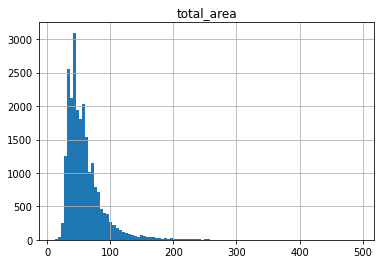

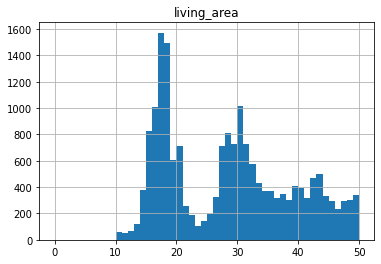

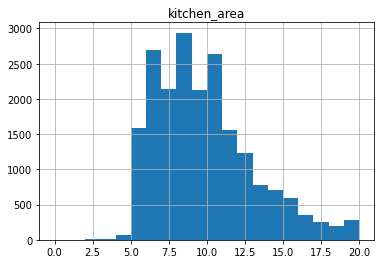

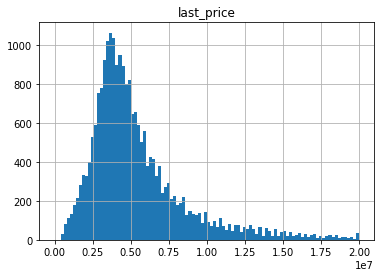

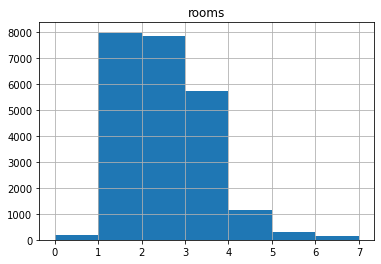

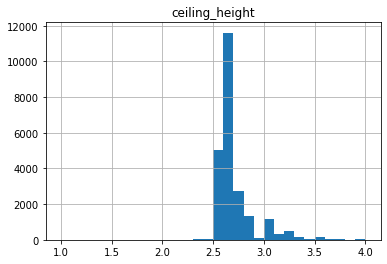

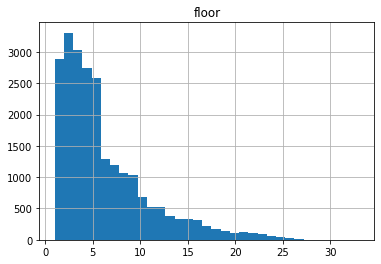

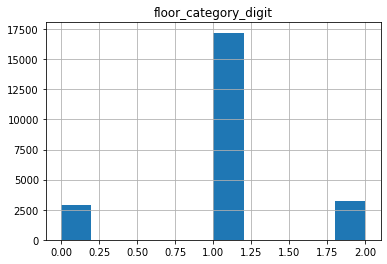

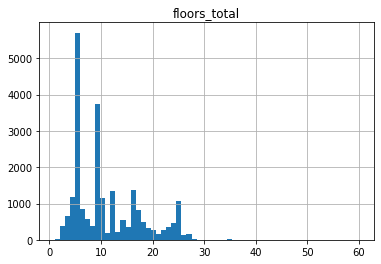

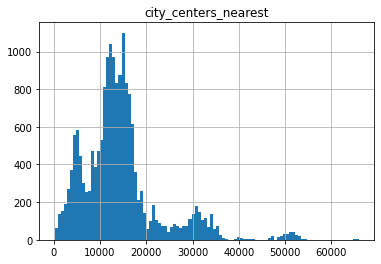

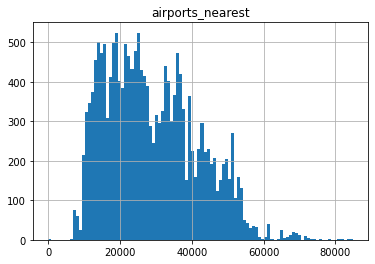

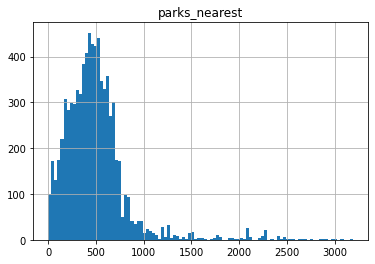

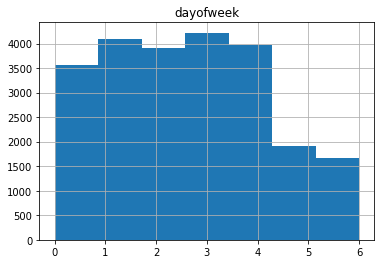

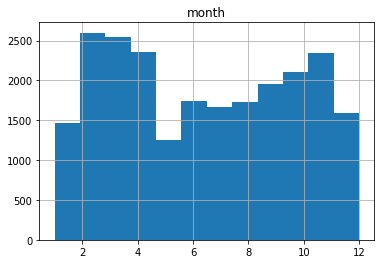

In [37]:
data.hist('total_area', bins=100);

data.hist('living_area', bins=50, range=(0,50));

data.hist('kitchen_area', bins=20, range=(0,20));

data.hist('last_price', bins=100, range=(0,2e+07));

data.hist('rooms', bins=data['rooms'].max());

data.hist('ceiling_height', bins=30);

data.hist('floor', bins=data['floor'].max())

data.hist('floor_category_digit');

data.hist('floors_total', bins=data['floors_total'].max());

data.hist('city_centers_nearest', bins=100);

data.hist('airports_nearest', bins=100);

data.hist('parks_nearest', bins=100);

data.hist('dayofweek', bins=7);

data.hist('month', bins=12)

Общая площадь: 
Наблюдаем очень малое количество квартир с общей площадью более 100 кв.м.

жилая площадь:
Наблюдаем два пика - на 18 кв.м. и на 30 кв.м. 

площадь кухни:
Данные по площади кухни выглядят приемлемыми.

цена объекта:
Цена объекта выглядит хорошо. Очень длинный "хвост" вправо - это похоже илитная недвижимость.

количество комнат:
Больше всего двух- и трёх-комнатных квартир, но встречаются и редкие исключения.

высота потолков:
Здесь два пика 2.5м и 3м.

этаж квартиры;
Больше всего квартир с 1 по 5 этаж. 

общее количество этажей в доме:
Наблюдаются явные пики: 5-этажная застройка, 9-этажная застройка.

расстояние до центра города в метрах;
Два пика, один маленький, 5км и другой побльшой от 10 км. до 15 км. 

расстояние до ближайшего аэропорта:
Не репрезентативно для нашего исследования.

расстояние до ближайшего парка:
Больше всего квартир с парками на расстоянии до 750м.

день и месяц публикации объявления:
Наблюдаем провал публикаций объявлений в субботу и воскресенье, что логично. Так же видим что с февраля по апрель наблюдалосась повышенная активность. Так же был плавный рост активности с июля по ноябрь. Провалы в декабре, январе и мае.

#### Изучите, как быстро продавались квартиры (столбец days_exposition).

Среднее время продажи квартиры в днях: 171
Медианное время продажи квартиры в днях: 93

[Выбросы] Количество объявлений, которые сняты через:
45 дней: 879
60 дней: 536
90 дней: 202


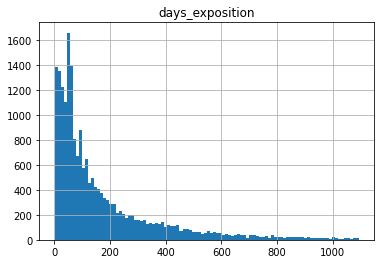

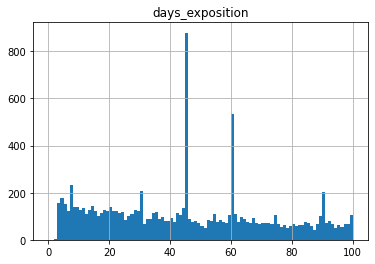

In [38]:
data.hist('days_exposition', bins=100);
data.hist('days_exposition', bins=100, range = (0,100));
print(f'Среднее время продажи квартиры в днях:',int(data['days_exposition'].mean()))
print('Медианное время продажи квартиры в днях:',int(data['days_exposition'].median()))

print('\n[Выбросы] Количество объявлений, которые сняты через:')
print('45 дней:',data[data['days_exposition']==45]['days_exposition'].count())
print('60 дней:',data[data['days_exposition']==60]['days_exposition'].count())
print('90 дней:',data[data['days_exposition']==90]['days_exposition'].count())

Можно сказать, что среднее время продажи квартиры составляет 181 день или полгода. Но если взять медиану - то это 95 дней, в два раза меньше. Это потому, что есть пул квартир, которые продавались несколько лет.

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта

In [39]:
list_for_graph = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms',
                  'floor_category_digit'
                  ]

for entry in list_for_graph:
    correlation = data['last_price'].corr(data[entry])
    print(f'Корреляция между last_price и {entry} составляет: {correlation:0.2%}')

Корреляция между last_price и total_area составляет: 75.50%
Корреляция между last_price и living_area составляет: 66.53%
Корреляция между last_price и kitchen_area составляет: 55.89%
Корреляция между last_price и rooms составляет: 45.77%
Корреляция между last_price и floor_category_digit составляет: 5.67%


Построим графики для анализа звисимости цена от:
общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).

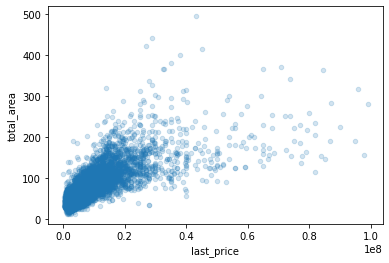

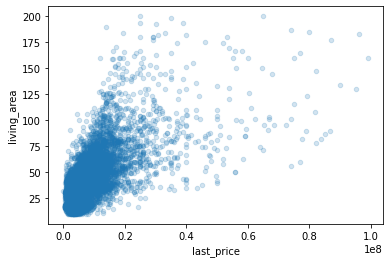

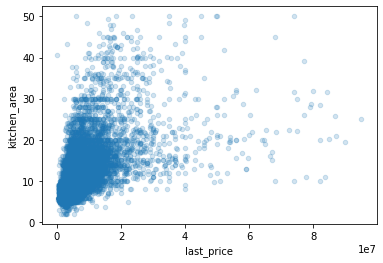

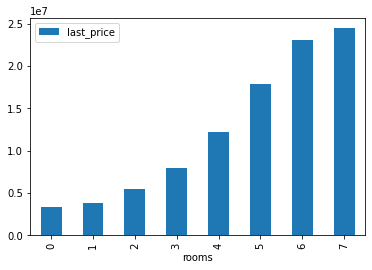

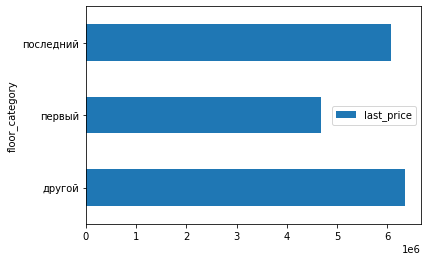

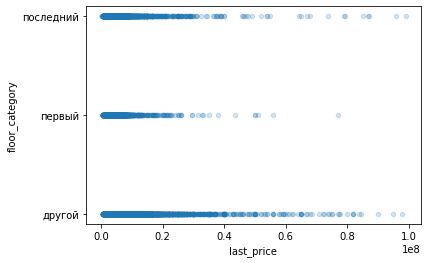

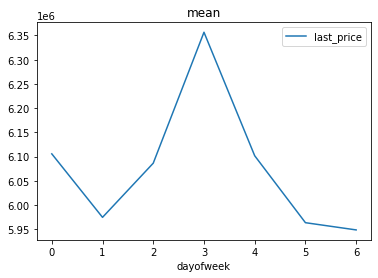

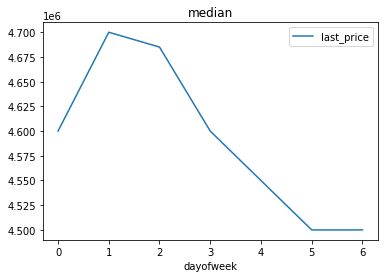

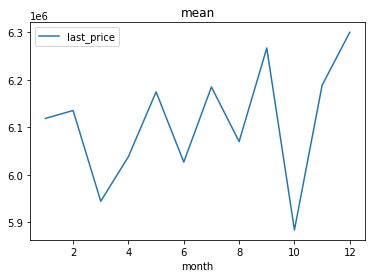

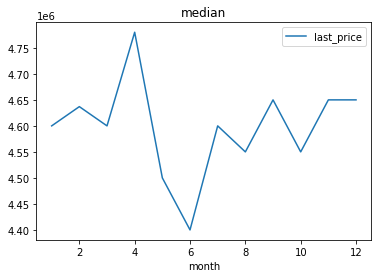

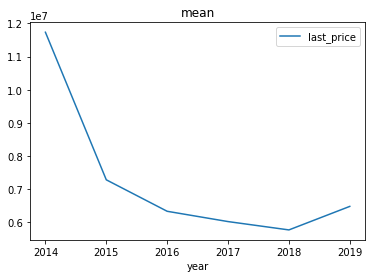

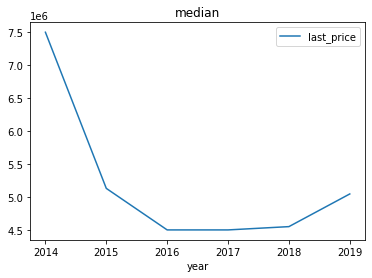

In [40]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.2)
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.2)
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.2)
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar');
data.pivot_table(index='floor_category',values='last_price').plot(y='last_price', kind='barh');
data.plot(x='last_price', y='floor_category', kind='scatter', alpha=0.2)


data.pivot_table(index='dayofweek',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='dayofweek',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='month',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='month',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='year',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='year',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

Цена по убыванию зависит от:

- общей площади;
- жилой площади;
- площади кухни;
- количества комнат.


Цена практически на зависит от:

этажа, на котором расположена квартира;
даты размещения.

#### Cредняя цена одного квадратного метра в топ-10 населенных пунктах

<AxesSubplot:ylabel='locality_name'>

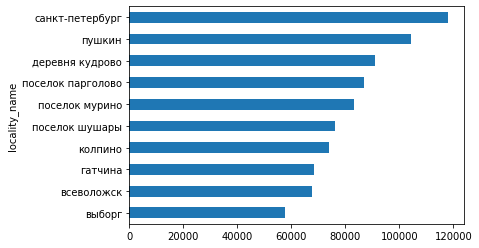

In [41]:
top_10 = data.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
top_10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count']
top_10.pop('total_area_count')
top_10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
top_10 = top_10.iloc[:10]
top_10['price_per_sq_m'] = top_10['last_price_sum']/top_10['total_area_sum']
top_10.sort_values(by=['price_per_sq_m'],ascending=True, inplace=True)
top_10['price_per_sq_m'].plot(kind='barh')

Смая дорогая недвижимость в Санкт-Петербурге.
В ТОП-10 входят ближайшие к Санкт-Петербургу города.

#### Как стоимость объектов зависит от расстояния до центра города.

<AxesSubplot:xlabel='city_centers_nearest_km'>

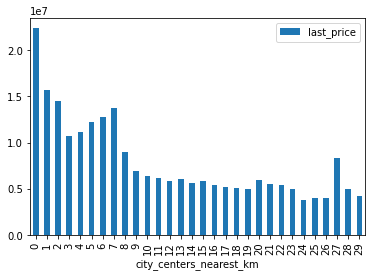

In [42]:
(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='city_centers_nearest_km',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
)

С большим отрывом лидирует недвижимость до 1 км.
Видим более низкие цены на недвижимость на расстоянии от 1 км. до 7 км. включительно.
Далее цена спадает на расстоянии от 8 км. до 27 км.
Видим пик на 27км, его сложно объяснить, возможно это недвижимость в "особом" районе.

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b>
<br>Верно 👍
</div>

### Общий вывод

Целью проекта было исследование данных по продаже недвижимости в Санкт-Петербурге и области. 
Анализ строился на основании данных, находящихся в файле  '/datasets/real_estate_data.csv'.
Предварительна оценка данных показала наличие следующих проблем:
- Пропуски данных: в нескольких столбцах имеются пропущенные значения. 
- Наличие дубликатов: необходимо проверить данные на явные и неявные дубликаты с целью удаления или замены. 
- Ошибки типов данных.
- Значения: наличие "длинных хвостов" у нескольких переменных, а также выбивающиеся значения. 
 
Все вышеизложенное было устранено в рамках предварительной работы с данными.
Для проведения исследования были добавлены дополнительные столбцы.
Проведено исследование на основематриц  корреляции и графиков зависимости одних перемен от других

По результатам проведенного анализа можно сделать следующие основные выводы:
Цена по убыванию зависит от следующих факторов:
общей площади;
жилой площади;
площади кухни;
количества комнат.

В 27 км от центра Санкт-Петербурга есть недвижимость по цене почти равная недвижимости в 8 км. от центра;

В ТОП-10 входят в основном ближайшие к Санкт-Петербургу города и самые крупные города области:
Пушкин;
Гатчина;
Всеволожск;
Выборг.

Быстрые продажи -  это до 90 дней, а необычно долгие - свыше 180 дней.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод